In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, mannwhitneyu, ttest_ind
import numpy as np

# Load the data
data = pd.read_csv('../results/experiment_results_1.csv')

data.head()

,run_type,run_number,energy_joules,execution_time_sec
0,gpu,13,456.454468,13.572708
1,cpu,9,4060.881607,58.558014
2,cpu,23,3968.708481,58.060480
3,gpu,1,407.374283,11.584133
4,cpu,14,3928.465271,57.569490


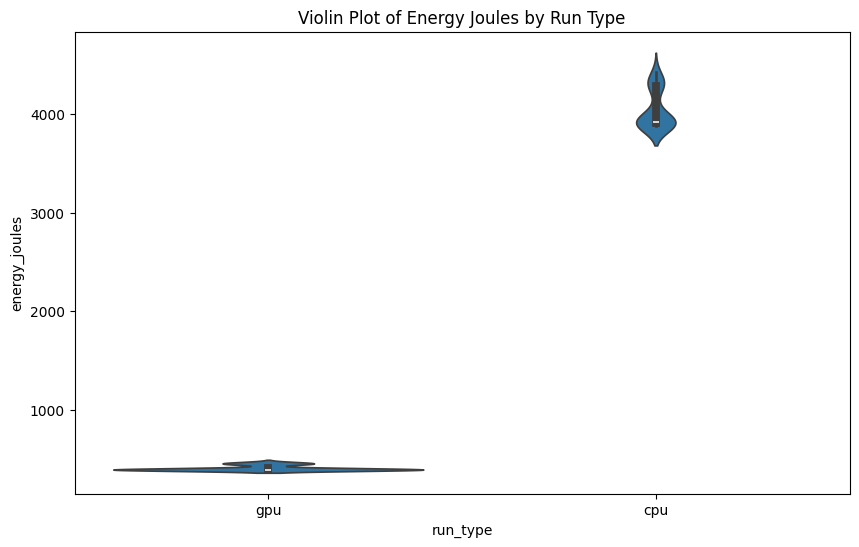

In [4]:

# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='run_type', y='energy_joules', data=data)
plt.title('Violin Plot of Energy Joules by Run Type')
plt.show()

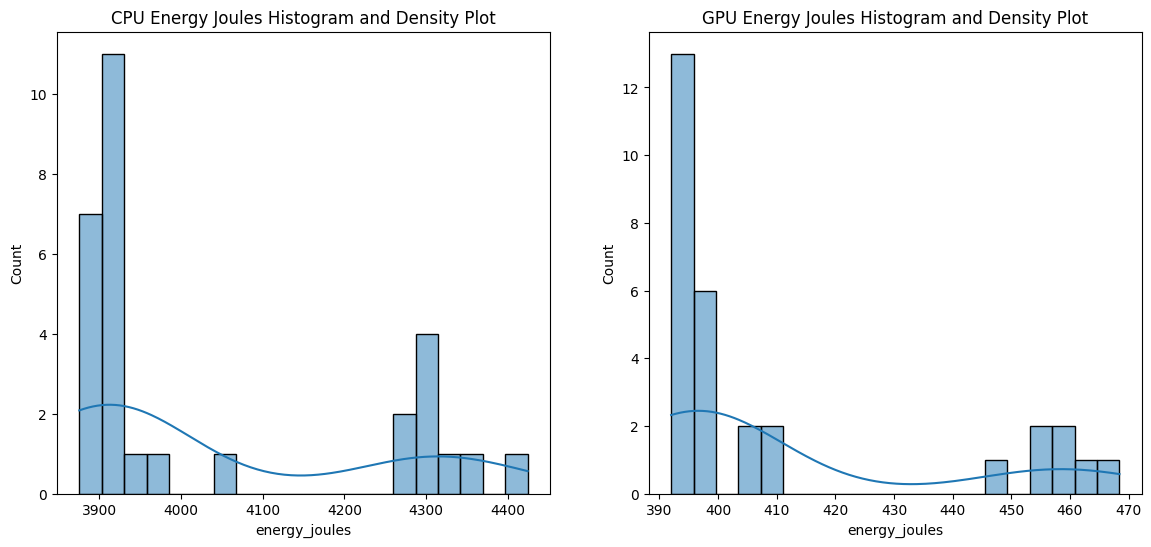

In [5]:

# Histograms and density plots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data[data['run_type'] == 'cpu']['energy_joules'], kde=True, bins=20)
plt.title('CPU Energy Joules Histogram and Density Plot')

plt.subplot(1, 2, 2)
sns.histplot(data[data['run_type'] == 'gpu']['energy_joules'], kde=True, bins=20)
plt.title('GPU Energy Joules Histogram and Density Plot')

plt.show()

In [6]:

# Shapiro-Wilk test for normality
cpu_data = data[data['run_type'] == 'cpu']['energy_joules']
gpu_data = data[data['run_type'] == 'gpu']['energy_joules']

shapiro_cpu = shapiro(cpu_data)
shapiro_gpu = shapiro(gpu_data)

print(f'Shapiro-Wilk Test for CPU: W={shapiro_cpu.statistic}, p-value={shapiro_cpu.pvalue}')
if shapiro_cpu.pvalue < 0.05:
    print('CPU data is NOT normally distributed')
else:
    print('CPU data is normally distributed')
print(f'Shapiro-Wilk Test for GPU: W={shapiro_gpu.statistic}, p-value={shapiro_gpu.pvalue}')
if shapiro_gpu.pvalue < 0.05:
    print('GPU data is NOT normally distributed')
else:
    print('GPU data is normally distributed')

Shapiro-Wilk Test for CPU: W=0.7246073484420776, p-value=3.6325989185570506e-06
CPU data is NOT normally distributed
Shapiro-Wilk Test for GPU: W=0.6554536819458008, p-value=3.7298170241228945e-07
GPU data is NOT normally distributed


If data is not normally distributed try removing outliers. If date is normally distributed skip this cell.

In [7]:
cpu_data_size = len(cpu_data)
gpu_data_size = len(gpu_data)
# remove outliers
cpu_data = cpu_data[cpu_data.between(cpu_data.quantile(0.05), cpu_data.quantile(0.95))]
gpu_data = gpu_data[gpu_data.between(gpu_data.quantile(0.05), gpu_data.quantile(0.95))]

print(f'CPU data: {cpu_data_size} -> {len(cpu_data)}')
print(f'GPU data: {gpu_data_size} -> {len(gpu_data)}')
# test if data is normally distributed
shapiro_cpu = shapiro(cpu_data)
shapiro_gpu = shapiro(gpu_data)

print(f'Shapiro-Wilk Test for CPU: W={shapiro_cpu.statistic}, p-value={shapiro_cpu.pvalue}')
if shapiro_cpu.pvalue < 0.05:
    print('CPU data is not normally distributed')
else:
    print('CPU data is normally distributed')
    
print(f'Shapiro-Wilk Test for GPU: W={shapiro_gpu.statistic}, p-value={shapiro_gpu.pvalue}')
if shapiro_gpu.pvalue < 0.05:
    print('GPU data is not normally distributed')
else:
    print('GPU data is normally distributed')

CPU data: 30 -> 26
GPU data: 30 -> 26
Shapiro-Wilk Test for CPU: W=0.681270956993103, p-value=2.9691275358345592e-06
CPU data is not normally distributed
Shapiro-Wilk Test for GPU: W=0.6163480877876282, p-value=4.58866537655922e-07
GPU data is not normally distributed


If data is normally distributed:

In [22]:

# Welch's t-test
t_test = ttest_ind(cpu_data, gpu_data, equal_var=False)

mean_cpu = np.mean(cpu_data)
mean_gpu = np.mean(gpu_data)
mean_diff = mean_gpu - mean_cpu
percent_change = (mean_diff / mean_cpu) * 100
cohen_d = (mean_diff) / np.sqrt((np.std(cpu_data) ** 2 + np.std(gpu_data) ** 2) / 2)

print(f'Welch\'s t-test: t-statistic={t_test.statistic}, p-value={t_test.pvalue}')
print(f'Mean CPU: {mean_cpu}')
print(f'Mean GPU: {mean_gpu}')
print(f'Mean Difference: {mean_diff}')
print(f'Percent Change: {percent_change}%')
print(f'Cohen\'s d: {cohen_d}')

Welch's t-test: t-statistic=-1.2836490241982117, p-value=0.20587086204948093
Mean CPU: 370.9768432617187
Mean GPU: 376.17877604166665
Mean Difference: 5.201932779947924
Percent Change: 1.4022257384615342%
Cohen's d: 0.3371027488226617


If data is not normally distributed:

In [8]:
# Mann-Whitney U test
u_test = mannwhitneyu(cpu_data, gpu_data, alternative='two-sided')

median_cpu = np.median(cpu_data)
median_gpu = np.median(gpu_data)
median_diff = median_gpu - median_cpu

# Calculate percentage of pairs
n1 = len(cpu_data)
n2 = len(gpu_data)
U = u_test.statistic
percent_pairs = U / (n1 * n2) * 100

# Common language effect size
cl_effect_size = U / (n1 * n2)

print(f'Mann-Whitney U test: U-statistic={u_test.statistic}, p-value={u_test.pvalue}')
print(f'Median CPU: {median_cpu}')
print(f'Median GPU: {median_gpu}')
print(f'Median Difference: {median_diff}')
print(f'Percentage of Pairs: {percent_pairs}%')
print(f'Common Language Effect Size: {cl_effect_size}')

Mann-Whitney U test: U-statistic=676.0, p-value=6.547526643655622e-10
Median CPU: 3921.898483276367
Median GPU: 396.2340316772461
Median Difference: -3525.664451599121
Percentage of Pairs: 100.0%
Common Language Effect Size: 1.0
